In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve

In [2]:
# Cell 2: Load data
X_train = pd.read_csv("../data/raw/X_train_G3tdtEn.csv")
y_train = pd.read_csv("../data/raw/Y_train_2_XPXJDyy.csv")
X_test = pd.read_csv("../data/raw/X_test_8skS2ey.csv")

/Users/drmohamed/Desktop/repos/detection-fraud-bnp-clean/.venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/drmohamed/Desktop/repos/detection-fraud-bnp-clean/.venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Cell 3: Format label
y_train = y_train["fraud_flag"]

In [4]:
# Cell 4: Preprocessing pipeline
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64'] and col != 'ID']
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=True))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

In [5]:
# Cell 5: Train/test split
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

X_train_part[cat_cols] = X_train_part[cat_cols].astype(str)
X_val_part[cat_cols] = X_val_part[cat_cols].astype(str)

In [ ]:
# Cell 6: Define stacking model (optimized for speed)
base_learners = [
    ("lgbm", LGBMClassifier(n_estimators=30, random_state=42, n_jobs=1)),
    ("rf", RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=1))
]

stack_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=500, class_weight="balanced"),
    n_jobs=1  # ← Important
    ))
])

In [7]:
# Cell 7: Fit stacking model
stack_model.fit(X_train_part, y_train_part)

[LightGBM] [Info] Number of positive: 1055, number of negative: 73177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.630694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5078
[LightGBM] [Info] Number of data points in the train set: 74232, number of used features: 1401
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014212 -> initscore=-4.239340
[LightGBM] [Info] Start training from score -4.239340
[LightGBM] [Info] Number of positive: 844, number of negative: 58541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.439268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4533
[LightGBM] [Info] Number of data points in the train set: 59385, number of used features: 1209
[LightGBM] [Info]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cash_price1', 'cash_price2',
                                                   'cash_price3', 'cash_price4',
                                                   'cash_price5', 'cash_price6',
                                                   'cash_price7', 'cash_price8',
                                                   'cash_price9',
                                                   'cash_price10',
                                                   'cash_price11',
                                         

In [8]:
stack_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cash_price1', 'cash_price2',
                                                   'cash_price3', 'cash_price4',
                                                   'cash_price5', 'cash_price6',
                                                   'cash_price7', 'cash_price8',
                                                   'cash_price9',
                                                   'cash_price10',
                                                   'cash_price11',
                                         

In [9]:
# Cell 8: Evaluate on validation
y_val_proba = stack_model.predict_proba(X_val_part)[:, 1]
pr_auc = average_precision_score(y_val_part, y_val_proba)
print(f"Stacked Model Validation PR-AUC: {pr_auc:.4f}")

Stacked Model Validation PR-AUC: 0.2011


In [10]:
# Cell 9: Retrain on full training set and predict
X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)
stack_model.fit(X_train, y_train)

# Save model
os.makedirs("../output", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump(stack_model, f"../output/stacking_model_{timestamp}.joblib")

# Predict on test
y_test_pred = stack_model.predict_proba(X_test)[:, 1]

# Format submission
submission = pd.DataFrame({
    "index": range(len(X_test)),
    "ID": X_test["ID"],
    "fraud_flag": y_test_pred
})

# Validation du format
expected_cols = ["index", "ID", "fraud_flag"]
assert submission.shape[1] == 3, "Le fichier de soumission doit avoir 3 colonnes : index, ID, fraud_flag"
assert submission.columns.tolist() == expected_cols, f"Les colonnes doivent être exactement {expected_cols}"
assert submission["fraud_flag"].between(0, 1).all(), "Toutes les probabilités doivent être entre 0 et 1"
assert submission["ID"].is_unique, "Chaque ID doit être unique"
assert (submission["index"] == range(len(submission))).all(), "La colonne index doit être une séquence de 0 à N-1"

submission.to_csv("../output/submission_stacking.csv", index=False)
print("✅ Submission saved to ../output/submission_stacking.csv")

[LightGBM] [Info] Number of positive: 1319, number of negative: 91471
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.915769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5815
[LightGBM] [Info] Number of data points in the train set: 92790, number of used features: 1638
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014215 -> initscore=-4.239148
[LightGBM] [Info] Start training from score -4.239148
[LightGBM] [Info] Number of positive: 1056, number of negative: 73176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.653322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5119
[LightGBM] [Info] Number of data points in the train set: 74232, number of used features: 1407
[LightGBM] [Info

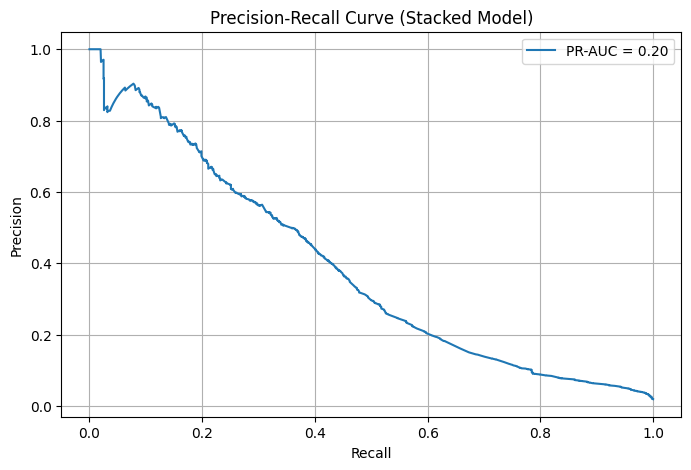

In [11]:
# Cell 10: Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_train, stack_model.predict_proba(X_train)[:, 1])
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Stacked Model)")
plt.legend()
plt.grid()
plt.show()